In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
# install platexenc for mpl qcircuit display?
!pip install pylatexenc

     |████████████████████████████████| 6.0MB 4.2MB/s 
     |████████████████████████████████| 18.0MB 133kB/s 
     |████████████████████████████████| 235kB 40.2MB/s 
     |████████████████████████████████| 215kB 44.9MB/s 
     |████████████████████████████████| 2.1MB 14.6MB/s 
     |████████████████████████████████| 1.5MB 32.7MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 194kB 41.5MB/s 
     |████████████████████████████████| 112kB 43.1MB/s 
     |████████████████████████████████| 614kB 31.3MB/s 
     |████████████████████████████████| 3.2MB 35.8MB/s 
     |████████████████████████████████| 6.3MB 31.5MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.2-cp37-none-any.whl size=10506 sha256=641946bd25ca0f54f707928d321f5895ff044eb5835d6979772b50a6b1ba4aab
  Stored in directory: /root/.cache/pip/wheels/89/89/34/524839952d5a58a7be9789e580bfc1ca883bf6579152444568
  Created wheel for python-constraint: filename=python_constraint-1.4.0-

In [ ]:
##############################################################################
# QNN Operating on MNIST data set
# Matthew Dobson
# github - https://github.com/mrdobson
# 
##############################################################################
# some of these packages are not necessary, will cull when code is in a better spot
import numpy as np
import matplotlib.pyplot as plt
import time

from torch import tensor
from torch import cat, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, 
                      MaxPool2d, Flatten, Sequential, ReLU, CrossEntropyLoss)
import torch.optim as optim
import torch.nn.functional as F

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
# ---------------
# mode parameters:
#    toggle these to customize behavior of the system
# ---------------
# will eventually turn this into a better "mode select"

#qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

# define number of qubits
num_inputs = 3

# modify these parameters to change which two characters we're going to
# compare against in the model, want to expand to 3 and then on
if num_inputs == 2:
    samp_val_1 = 4
    samp_val_2 = 9

# MNIST Data Load for Training Set

In [ ]:
# number of samples for training
n_samples = 7000

# returns tuple with X_train.data and X_train.targets <-- what I don't have from iris
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# if we are using the limited dataset (two classes) must preprocess dataset a bit
if num_inputs == 2:
    # extract only two classifications into data, defined by samp_val 1 and 2 configured above
    idx = np.append(np.where(X_train.targets == samp_val_1)[0][:n_samples],
                    np.where(X_train.targets == samp_val_2)[0][:n_samples])
    
    # preprocessing for training data, limit the scope of our classifications
    X_train.data = X_train.data[idx]
    X_train.targets = X_train.targets[idx]

    # samp vals tunable above in the settings, this is to fit to our data loader
    X_train.targets[X_train.targets==samp_val_1] = 0
    X_train.targets[X_train.targets==samp_val_2] = 1
    ### DEBUG    
    #print("xtrain targets ", X_train.targets, "\n")

else:
    # limit to num_samples of training set
    X_train.data = X_train.data[:n_samples]
    X_train.targets = X_train.targets[:n_samples]
    #### DEBUG
    #print("xtrain data ", X_train.data)
    #print("xtrain targets ", X_train.targets)

In [ ]:
# perform training load
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)

# MNIST Data Load for Testing Set

In [ ]:
# number of samples for testing
n_samples = 3000

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
if num_inputs == 2:
    # extract only two classifications into data, defined by samp_val 1 and 2 configured above
    idx = np.append(np.where(X_test.targets == samp_val_1)[0][:n_samples], 
                    np.where(X_test.targets == samp_val_2)[0][:n_samples])
    
    # preprocessing for test data, limit scope
    X_test.data = X_test.data[idx]
    X_test.targets = X_test.targets[idx]

    # samp vals tunable above in the settings, to fit to data loader
    X_test.targets[X_test.targets==samp_val_1] = 0
    X_test.targets[X_test.targets==samp_val_2] = 1
    ### DEBUG    
    #print("xtest targets ", X_train.targets, "\n")

else:
    # limit to num_samples of training set
    X_test.data = X_test.data[:n_samples]
    X_test.targets = X_test.targets[:n_samples]
    #### DEBUG
    #print("xtrain data ", X_test.data)
    #print("xtrain targets ", X_test.targets)

In [ ]:
# perform testing load
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

# Define QNN

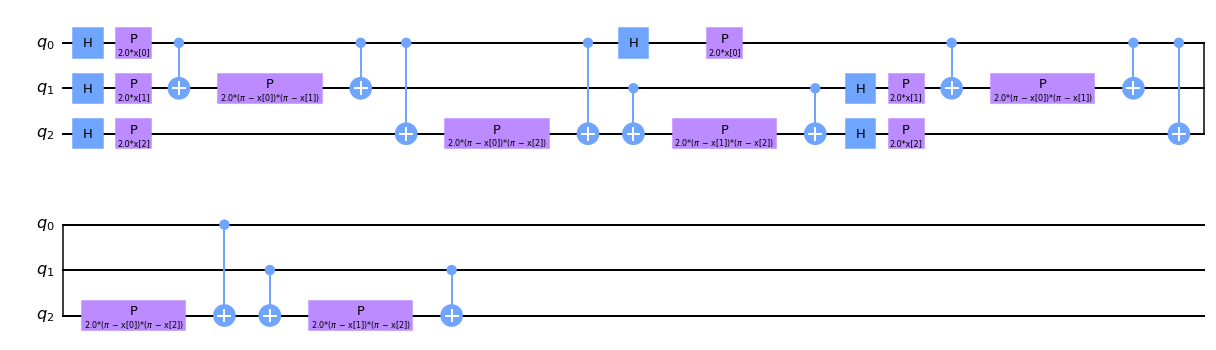

In [ ]:
# ZZ is 2nd order Pauli expansion circuit
fm = ZZFeatureMap(num_inputs)
fm.draw(output='mpl')

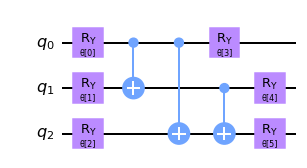

In [ ]:
# RealAmplitudes is used as an ansatz for ML, heuristic trial wave func
ansatz = RealAmplitudes(num_inputs, reps=1)
ansatz.draw(output='mpl')

In [ ]:
# define observable
observable = PauliSumOp.from_list([('Z'*num_inputs, 1)])
print(observable)

1.0 * ZZZ


In [ ]:
# define two layer QNN
qnn = TwoLayerQNN(num_inputs, 
                  feature_map=fm, 
                  ansatz=ansatz, 
                  observable=observable,
                  quantum_instance=qi)
print(qnn.operator)
print(qnn.output_shape)

print(type(qnn))

ComposedOp([
  OperatorMeasurement(1.0 * ZZZ),
  CircuitStateFn(
       ┌─────────────────────────┐┌────────────────────────────────────────┐
  q_0: ┤0                        ├┤0                                       ├
       │                         ││                                        │
  q_1: ┤1 nlocal(x[0],x[1],x[2]) ├┤1 nlocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) ├
       │                         ││                                        │
  q_2: ┤2                        ├┤2                                       ├
       └─────────────────────────┘└────────────────────────────────────────┘
  )
])
(1,)
<class 'qiskit_machine_learning.neural_networks.two_layer_qnn.TwoLayerQNN'>


In [ ]:
# create the QNN model
# have a Net2 model and a Net3_plus model that we can toggle between based on top level config
class Net(Module):

    def __init__(self):
        super().__init__()
        # how this works:
        # torch.nn.functional.conv2d(input, weight, bias=None, stride=1, 
        # padding=0, dilation=1, groups=1) → Tensor
        self.conv1 = Conv2d(1, 3, kernel_size=5) # input 1, output 3, 5x5 kernel
        self.conv2 = Conv2d(3, 32, kernel_size=5) # input 3, output 32, 5x5 kernel
        self.dropout = Dropout2d()
        self.fc1 = Linear(512, 128)
        self.fc2 = Linear(128, 3)         # 3-dimensional input to QNN
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 10)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x)) # relu activation on 5x5 kernel 1in 3out conv
        x = F.max_pool2d(x, 2) # applies a 2D max pooling over an input signal composed of several input planes
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net()

In [ ]:
# define model, optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()
# Negative-log likelihood loss doesn't lend itself as well to this application
#loss_func = NLLLoss()

# Perform Model Training

In [ ]:
# start training timer
start_train = time.time()

epochs = 5    # set num epochs
loss_list = [] # store loss history
model.train()  # place model in training mode
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True) # init gradient
        output = model(data)             # forward pass
        ### DEBUG
        #print("target is: ", target)
        #print("output is: ", output)
        loss = loss_func(output, target) # calc loss
        loss.backward()                  # backward pass
        optimizer.step()                 # optimize weights
        total_loss.append(loss.item())   # store loss
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:0f}%]\tLoss: {:.4f}'.format(
           100. * (epoch + 1) / epochs, loss_list[-1]))

# finish training timer    
end_train = time.time()
print('Training runtime is: ', (end_train - start_train))

Training [20.000000%]	Loss: 2.4516
Training [40.000000%]	Loss: 2.0735
Training [60.000000%]	Loss: 1.9366
Training [80.000000%]	Loss: 1.8715
Training [100.000000%]	Loss: 1.8359


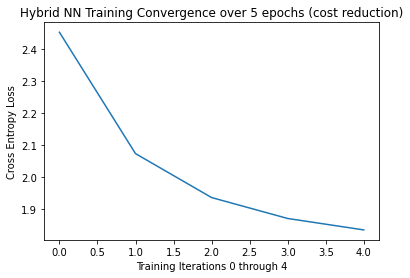

In [ ]:
plt.figure(3)
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence over {0} epochs (cost reduction)'.format(epochs))
plt.xlabel('Training Iterations 0 through {0}'.format(epochs - 1))
plt.ylabel('Cross Entropy Loss')
plt.show()

# Perform Evaluation

In [ ]:
# start eval time
start_eval = time.time()

model.eval() # set into eval mode
with no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
            
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    # batch_size goes where the 1 is here
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
           .format(sum(total_loss) / len(total_loss),
                correct / len(test_loader) / 1 * 100))
    
# end eval time
end_eval = time.time()
print('Evaluation time is: ', (end_eval - start_eval))

Performance on test data:
	Loss: 1.8362
	Accuracy: 21.3%
Evaluation time is:  44.362539529800415


In [ ]:
# display which two sample values are we comparing against?
print("MNIST sample 1 is {0}, sample 2 is {1}".format(samp_val_1, samp_val_2))

NameError: ignored

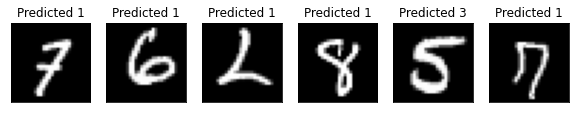

In [ ]:
# display accuracy of a handful of samples from testing dataset
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        # remap class values to samp_val 1 and 2
        # where pred == 0 set it to samp_val_1, same for pred == 1
        # below lines don't work for this, need to figure out another way but not critical
        #pred.item[pred.item()==0] = samp_val_1
        #pred.item[pred.item()==1] = samp_val_2

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1